# Bone suppression(U-Net)
参考：[Pix2Pix  |  TensorFlow Core](https://www.tensorflow.org/tutorials/generative/pix2pix#training)

## 前準備
### 主要パッケージのインポート

In [1]:
import pathlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image
from IPython.display import display
from logging import basicConfig, getLogger, INFO
basicConfig(level=INFO, format='%(asctime)s %(levelname)s :%(message)s')
logger = getLogger(__name__)

### データディレクトリの指定

In [2]:
DATA_ROOT = pathlib.Path('Data/Images/chest_xray')
INPUT_IMAGE_DIR = 'bone_enhancement'
TRUTH_IMAGE_DIR = 'bone_suppression'
CLASS_LABELS = ('lung')
IMAGE_EXT = '.png'

### 画像ファイルを基にpd.DataFrameを作成する

In [3]:
def create_dataset_df(data_root, input_dir, truth_dir, image_ext):
    dfs = []
    root = pathlib.Path(data_root)
    image_filenames = (root / pathlib.Path(input_dir)).glob('*' + image_ext)
    df = pd.DataFrame(image_filenames, columns=['input_path'])
    df['truth_path'] = df['input_path'].map(
        lambda p: root / pathlib.Path(truth_dir) / p.name)
    return df


df_dataset = create_dataset_df(DATA_ROOT, INPUT_IMAGE_DIR, TRUTH_IMAGE_DIR,
                               IMAGE_EXT)
display(df_dataset.head())

input_path  \
0  Data\Images\chest_xray\bone_enhancement\000.png   
1  Data\Images\chest_xray\bone_enhancement\001.png   
2  Data\Images\chest_xray\bone_enhancement\002.png   
3  Data\Images\chest_xray\bone_enhancement\003.png   
4  Data\Images\chest_xray\bone_enhancement\004.png   

                                        truth_path  
0  Data\Images\chest_xray\bone_suppression\000.png  
1  Data\Images\chest_xray\bone_suppression\001.png  
2  Data\Images\chest_xray\bone_suppression\002.png  
3  Data\Images\chest_xray\bone_suppression\003.png  
4  Data\Images\chest_xray\bone_suppression\004.png

### 画像を表示

<Figure size 720x360 with 0 Axes>

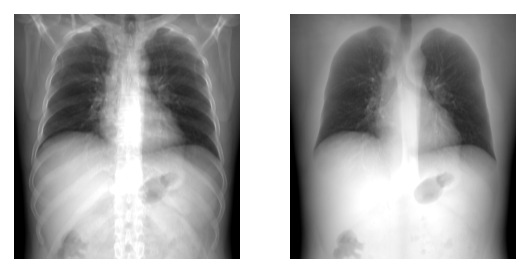

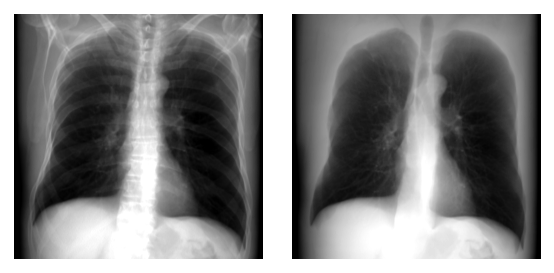

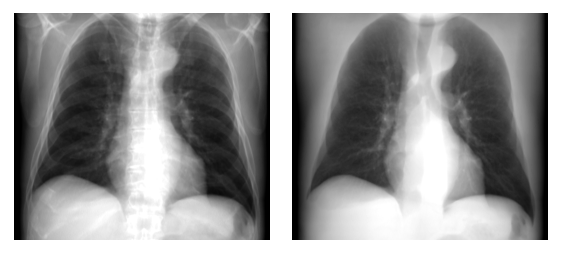

In [4]:
N_SAMPLES = 3
plt.figure(figsize=(10, 5))
for i, sample in enumerate(df_dataset.sample(n=N_SAMPLES).itertuples()):
    image = Image.open(sample.input_path)
    truth = Image.open(sample.truth_path)
    plt.figure(figsize=(4, 2))
    plt.subplot(1, 2, 1)
    plt.imshow(image, cmap='gray')
    plt.axis('off')
    plt.subplot(1, 2, 2)
    plt.imshow(truth, cmap='gray')
    plt.axis('off')
    plt.tight_layout()
    plt.show()

## モデル作成
構造はhttps://www.tensorflow.org/tutorials/generative/pix2pix のgeneratorを使う。

In [5]:
import tensorflow as tf


def downsample(filters, size, apply_batchnorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)

    result = tf.keras.Sequential()
    result.add(
        tf.keras.layers.Conv2D(filters,
                               size,
                               strides=2,
                               padding='same',
                               kernel_initializer=initializer,
                               use_bias=False))

    if apply_batchnorm:
        result.add(tf.keras.layers.BatchNormalization())

    result.add(tf.keras.layers.LeakyReLU())

    return result


def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)

    result = tf.keras.Sequential()
    result.add(
        tf.keras.layers.Conv2DTranspose(filters,
                                        size,
                                        strides=2,
                                        padding='same',
                                        kernel_initializer=initializer,
                                        use_bias=False))

    result.add(tf.keras.layers.BatchNormalization())

    if apply_dropout:
        result.add(tf.keras.layers.Dropout(0.5))

    result.add(tf.keras.layers.ReLU())

    return result

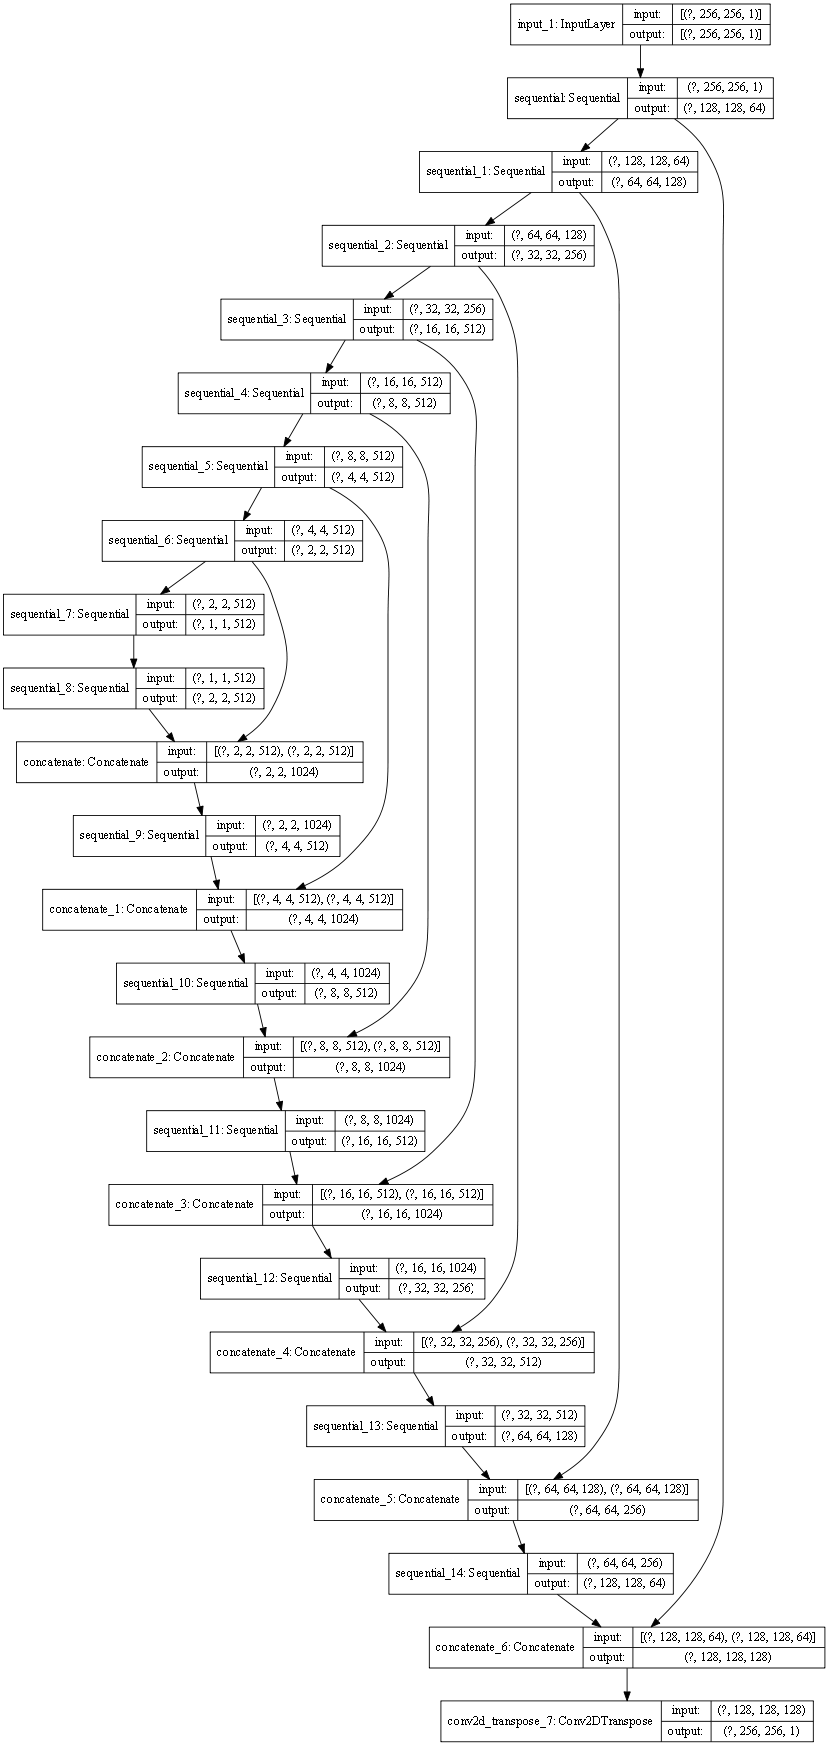

In [6]:
INPUT_SHAPE = [256, 256, 1]
OUTPUT_CHANNELS = 1


def Generator():
    inputs = tf.keras.layers.Input(shape=INPUT_SHAPE)

    down_stack = [
        downsample(64, 4, apply_batchnorm=False),  # (bs, 128, 128, 64)
        downsample(128, 4),  # (bs, 64, 64, 128)
        downsample(256, 4),  # (bs, 32, 32, 256)
        downsample(512, 4),  # (bs, 16, 16, 512)
        downsample(512, 4),  # (bs, 8, 8, 512)
        downsample(512, 4),  # (bs, 4, 4, 512)
        downsample(512, 4),  # (bs, 2, 2, 512)
        downsample(512, 4),  # (bs, 1, 1, 512)
    ]

    up_stack = [
        upsample(512, 4, apply_dropout=True),  # (bs, 2, 2, 1024)
        upsample(512, 4, apply_dropout=True),  # (bs, 4, 4, 1024)
        upsample(512, 4, apply_dropout=True),  # (bs, 8, 8, 1024)
        upsample(512, 4),  # (bs, 16, 16, 1024)
        upsample(256, 4),  # (bs, 32, 32, 512)
        upsample(128, 4),  # (bs, 64, 64, 256)
        upsample(64, 4),  # (bs, 128, 128, 128)
    ]

    initializer = tf.random_normal_initializer(0., 0.02)
    last = tf.keras.layers.Conv2DTranspose(
        OUTPUT_CHANNELS,
        4,
        strides=2,
        padding='same',
        kernel_initializer=initializer,
        activation='linear')  # (bs, 256, 256, 3)

    x = inputs

    # Downsampling through the model
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = tf.keras.layers.Concatenate()([x, skip])

    x = last(x)

    return tf.keras.Model(inputs=inputs, outputs=x)


generator = Generator()
tf.keras.utils.plot_model(generator, show_shapes=True, dpi=64)

### Compile
lossはMeanSquaredErrorをつかう。

In [7]:
generator.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss=tf.keras.losses.MeanSquaredError(),
)

## 学習
### ホールドアウト

In [8]:
from sklearn.model_selection import KFold
N_SPLITS = 5
SEED = 0
kfold = KFold(n_splits=N_SPLITS, shuffle=True, random_state=SEED)
train_index, test_index = next(kfold.split(df_dataset['input_path']))

df_train = df_dataset.iloc[train_index]
df_test = df_dataset.iloc[test_index]

In [9]:
import tqdm
IMG_SHAPE = INPUT_SHAPE


def load_img(filepath):
    return np.atleast_3d(
        tf.keras.preprocessing.image.load_img(filepath,
                                              color_mode='grayscale',
                                              target_size=IMG_SHAPE))


dataset = tf.data.Dataset.from_tensor_slices((
    np.stack([
        load_img(filepath) for filepath in tqdm.tqdm(df_train['input_path'])
    ]),
    np.stack([
        load_img(filepath) for filepath in tqdm.tqdm(df_train['truth_path'])
    ]),
))

print(dataset.element_spec)

100%|██████████| 228/228 [00:00<00:00, 260.59it/s]

(TensorSpec(shape=(256, 256, 1), dtype=tf.uint8, name=None), TensorSpec(shape=(256, 256, 1), dtype=tf.uint8, name=None))


### Data augmentation

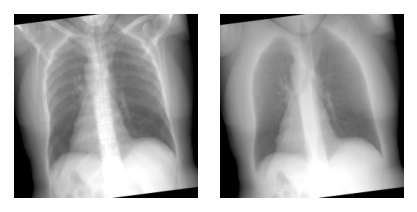

In [10]:
import tensorflow_addons as tfa


def convert(image, truth):
    image = tf.image.convert_image_dtype(image, tf.float32)
    truth = tf.image.convert_image_dtype(truth, tf.float32)
    return image, truth


MAX_ANGLE_DEG = 10
MAX_ANGLE_RAD = np.deg2rad(MAX_ANGLE_DEG)
FLIP_RATE = .5
BRIGHTNESS_RANGE = .2


def augment(image, truth):
    image, truth = convert(image, truth)
    # rotate
    angle = tf.random.uniform((), minval=-MAX_ANGLE_RAD, maxval=MAX_ANGLE_RAD)
    image = tfa.image.rotate(image, angle, interpolation='BILINEAR')
    truth = tfa.image.rotate(truth, angle, interpolation='BILINEAR')

    # flip
    if tf.random.uniform(()) < FLIP_RATE:
        image = tf.image.flip_left_right(image)
        truth = tf.image.flip_left_right(truth)

    # brightness
    brightness_offset = tf.random.uniform((),
                                          minval=-BRIGHTNESS_RANGE,
                                          maxval=BRIGHTNESS_RANGE)
    image = image + brightness_offset
    truth = truth + brightness_offset

    return image, truth


for d in dataset.map(augment):
    plt.figure(figsize=(3, 2))
    plt.subplot(1, 2, 1)
    plt.imshow(d[0][..., 0], cmap='gray')
    plt.axis('off')
    plt.subplot(1, 2, 2)
    plt.imshow(d[1][..., 0], cmap='gray')
    plt.axis('off')
    plt.tight_layout()
    plt.show()
    break

### fit

In [11]:
import tut_utils

AUTOTUNE = tf.data.experimental.AUTOTUNE

EPOCHS = 256
PATIENCE = 16
LR_PATIENCE = PATIENCE // 2
BATCH_SIZE = 4

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss',
                                                  restore_best_weights=True,
                                                  patience=PATIENCE,
                                                  min_delta=5e-6)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='loss',
                                                 factor=0.5,
                                                 patience=LR_PATIENCE,
                                                 min_lr=1e-5)

logger.info('start of training')
with tut_utils.ProgressBarCallback(EPOCHS,
                                   len(train_index) // BATCH_SIZE,
                                   BATCH_SIZE) as pbar:
    result = generator.fit(dataset.shuffle(BATCH_SIZE * 16).map(
        augment,
        num_parallel_calls=AUTOTUNE).batch(BATCH_SIZE).prefetch(AUTOTUNE),
                           epochs=EPOCHS,
                           verbose=0,
                           shuffle=False,
                           callbacks=[pbar, early_stopping, reduce_lr])
logger.info('end of training')

2020-06-16 10:26:01,642 INFO :start of training
121/256 epoch [9.6m/20m (4.7s/epoch) last_epoch=(loss=0.000437)]: 100%|██████████| 228/228 [00:04<00:00, 47.53batch/s, loss=0.000406]
2020-06-16 10:35:35,759 INFO :end of training


<Figure size 216x288 with 0 Axes>

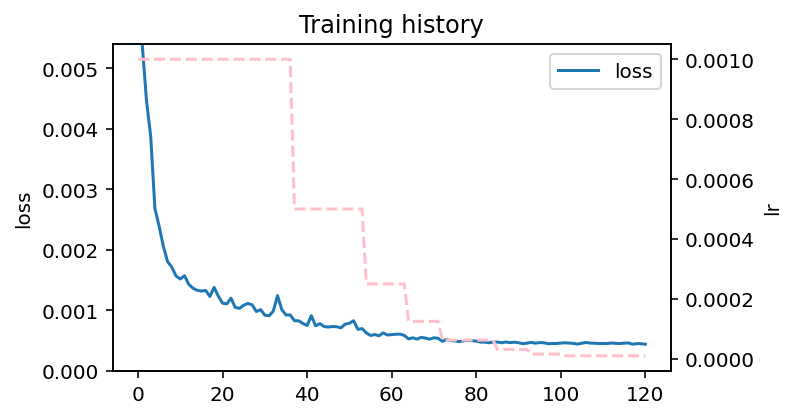

In [12]:
import copy
history = copy.copy(result.history)
lr_history = history.pop('lr', None)
plt.figure(figsize=(3, 4))
pd.DataFrame(history).plot(title='Training history', figsize=(5, 3))
plt.ylabel('loss')
plt.ylim(0, history['loss'][1])
if lr_history is not None:
    plt.gca().twinx().plot(lr_history, color='pink', linestyle='--', label='lr')
    plt.gca().set_ylabel('lr')
plt.show()

## 評価
準備中

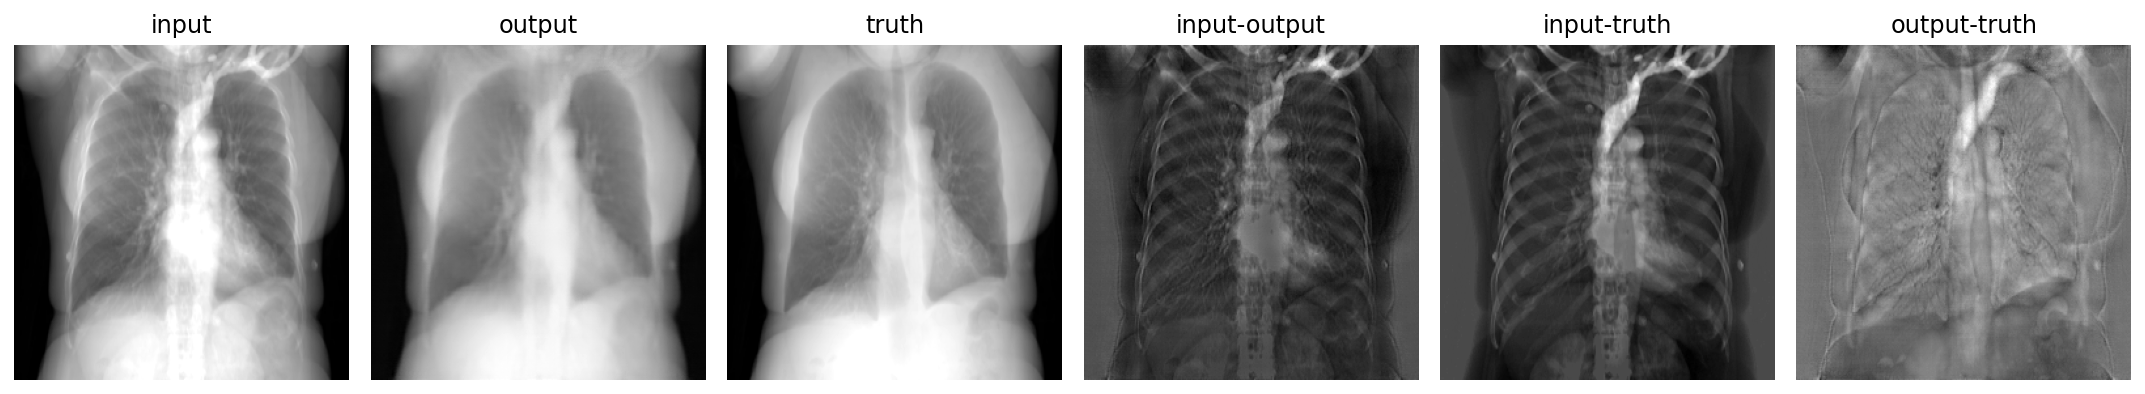

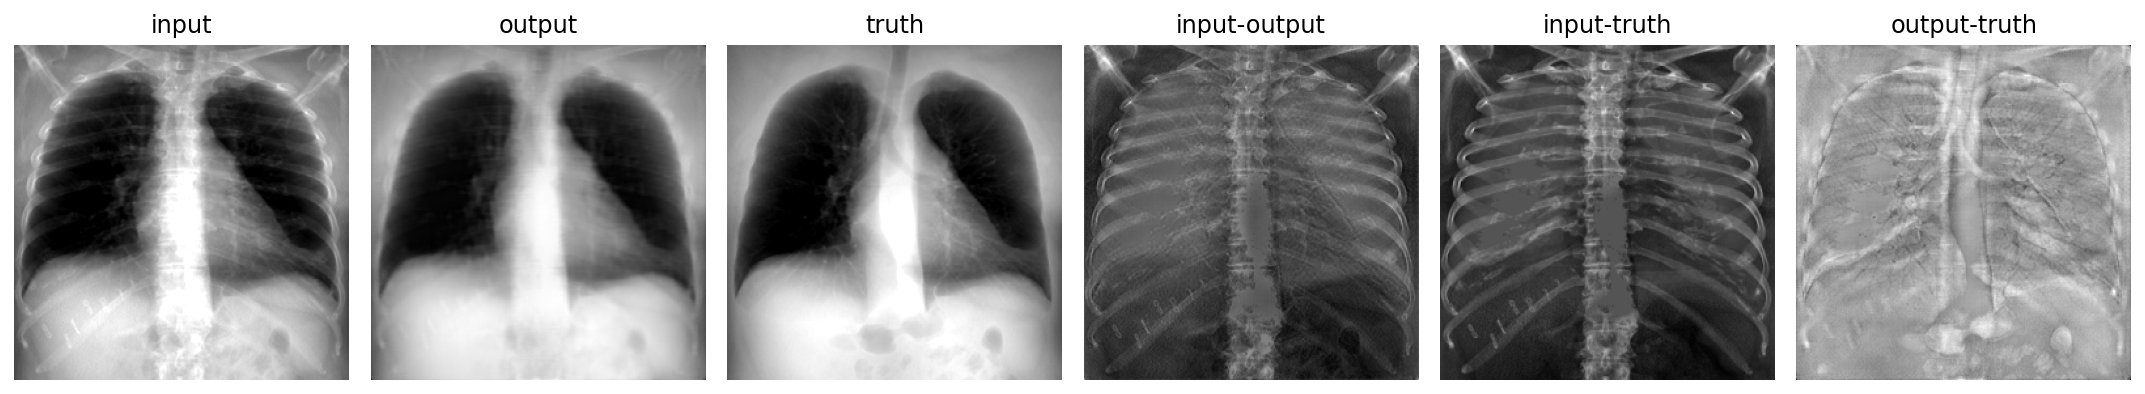

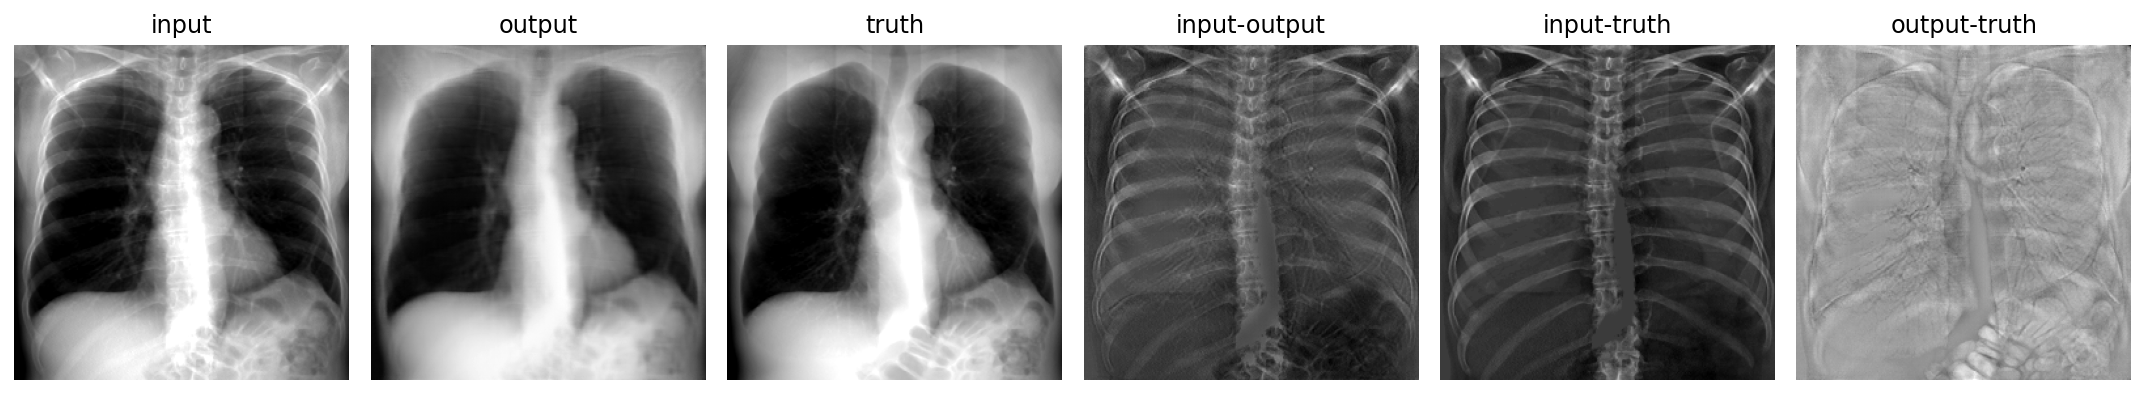

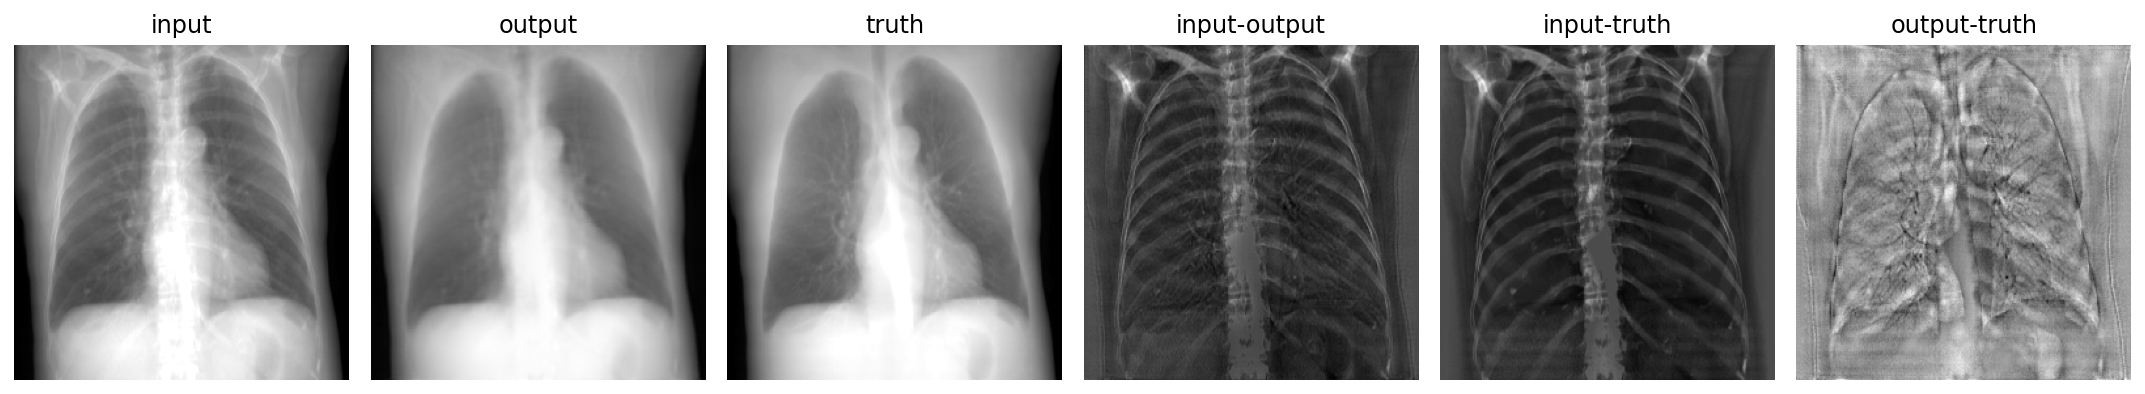

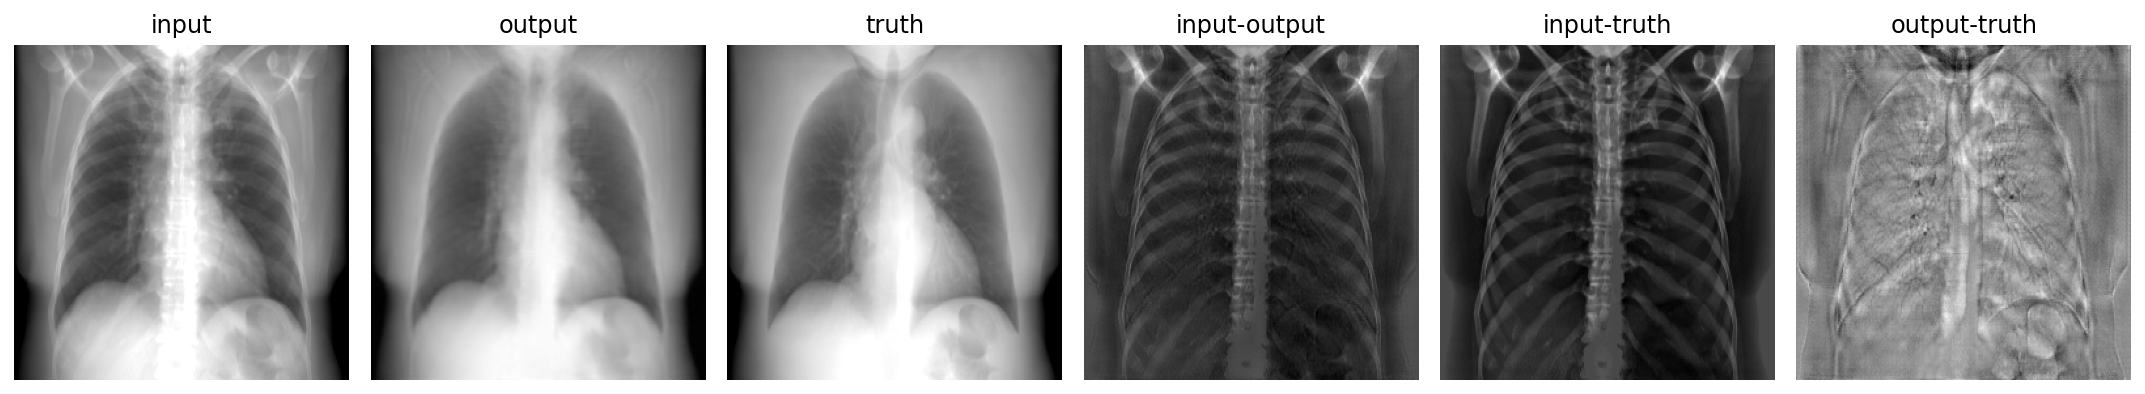

In [13]:
import math
from sklearn import metrics


def show_images_in_a_row(images, titles, figsize=(15, 5)):
    assert len(images) == len(titles), 'Invalid size of arguments'
    plt.figure(figsize=figsize)
    for i, (image, title) in enumerate(zip(images, titles), 1):
        plt.subplot(1, len(images), i)
        plt.imshow(image, cmap='gray')
        plt.title(title)
        plt.axis('off')
    plt.tight_layout()
    plt.show()


scores = []
for i, index in enumerate(test_index):
    image = tf.keras.preprocessing.image.load_img(
        df_dataset.iloc[index].input_path,
        color_mode='grayscale',
        target_size=IMG_SHAPE)
    truth = tf.keras.preprocessing.image.load_img(
        df_dataset.iloc[index].truth_path,
        color_mode='grayscale',
        target_size=IMG_SHAPE)
    truth = np.array(truth) / 255

    image = np.atleast_3d(image)
    image = np.array(image) / 255
    pred = generator.predict(image[np.newaxis]).squeeze()
    image = image.squeeze()
    if i < 5:
        show_images_in_a_row(*zip((image, 'input'), (pred, 'output'), (
            truth, 'truth'), (image - pred, 'input-output'), (
                image - truth, 'input-truth'), (pred - truth, 'output-truth')))
    else:
        break

In [14]:
generator.save('unet_generator.h5')